# The Tinbox Case

case description here

In [1]:
import pandas as pd
import numpy as np
import pyro 

from typing import Dict, List
from scipy.stats import entropy
from scipy.stats import beta
import pyro.distributions as dist
import torch

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

### Weight and Expected Weight of the evidence

In [3]:
def normalize_sample(sample: torch.Tensor, k: int = 1000) -> torch.Tensor:
    ''' 
    `sample` is supposed to be a sample of values, returns probabilites across k bins.
    '''

    hist = torch.histc(sample, bins=k)
    return hist / hist.sum()


\begin{equation*} 
entropy(p) = - \sum p_i log p_i
\end{equation*}


In [4]:

def weight(posterior: torch.Tensor, base=2.) -> float:
    '''
    Calculates the weight of the posterior distribution.
    The weight is defined as 1 - H(posterior) / H(uniform)
    where H is the entropy of the distribution.
        param: posterior: torch.Tensor - tensor of probabilities (not samples). 
    '''
    
    if not isinstance(base, torch.Tensor):  # Check if base is not a tensor
        base = torch.tensor(base) 

    initial_length = posterior.shape[-1]
    posterior = posterior[~torch.isnan(posterior)]
    removed_length = initial_length - posterior.shape[-1]

    if initial_length != posterior.shape[-1]:#raise warning
        warnings.warn(f"Removed {removed_length} nan values from posterior")

    if posterior.numel() == 0:
        return float('nan')

    grid_length = posterior.shape[-1]
    x = torch.linspace(0, 1, grid_length)

    uniform = dist.Beta(1, 1).log_prob(x).exp()
    uniform = uniform/uniform.sum()

    #uniform = normalize_sample(uniform, k = uniform.shape[-1])

    assert torch.allclose(uniform.sum(), torch.tensor(1.)), f"Sum of uniform distribution is {uniform.sum()}"
    assert torch.allclose(posterior.sum(), torch.tensor(1.)), f"Sum of posterior distribution is {posterior.sum()}"

    entropy_uniform = -torch.sum(uniform * torch.log(uniform) /torch.log(base))

    entropy_posterior = -torch.sum(posterior * torch.log(posterior) / torch.log(base))

    return 1 - entropy_posterior.item() / entropy_uniform.item()


\begin{equation*}
EXPVAL[E, PRIOR] = \sum_1^k P(S_i|PRIOR) \times VAL[E_i, PRIOR].
\end{equation*}

\begin{equation*}
E_{Vchange}[E, PRIOR] = \sum_1^k \left( P(E_i|PRIOR) \times \left[ VAL(POSTERIOR_{E_i}) - VAL(PRIOR) \right]\right) .
\end{equation*}

The `expected_weight` function returns a dictionary containing the following elements:

1. **`expected_weight`** - This is the overall expected change in the weight across possible values of the evidence. It combines both the prior information and how much the weight changes across all possible posteriors, adjusted by the probabilities of the evidence.

2. **`weight_prior`** -  This is the weight of the prior distribution, calculated before any evidence is observed.

3. **`posterior_weights`** - These values show how much the uncertainty (entropy) has changed for each posterior. If the posterior weight is close to 1, the posterior is more certain (less entropy). If it is close to 0, the posterior remains uncertain.

4. **`weight_changes`** - The difference between the weights of the posteriors and the prior. It measures how much each posterior's weight differs from the prior. 

5. **`weighted_weight_changes`** - The `weight_changes` values multiplied by the probabilities of the corresponding pieces of evidence (`probs_of_evidence`). This represents how much each piece of evidence contributes to the overall expected change in weight. 



<span style="color:red">Problem: probs. of evidence, are they dervied from prior probs. and the reliability of the evidence?</span>


In [5]:
def expected_weight(probs_of_evidence: torch.Tensor, outcome_prior: torch.Tensor,
                    posteriors: List[torch.Tensor],  base=2) -> torch.Tensor:    
    """
    Calculate the expected weight change given a prior distribution, 
    posterior distributions, and the probabilities of evidence.

    Args:
    probs_of_evidence (torch.Tensor): A tensor of probabilities representing the likelihood of the evidence.
    outcome_prior (torch.Tensor): A tensor representing the prior distribution of outcomes.
    posteriors (List[torch.Tensor]): A list of tensors representing the posterior distributions.
    base (int): The base for calculating the weight (default is 2).

    """
    
    weight_prior = weight(outcome_prior, base=base) 

    posterior_weights = torch.tensor([weight(posterior, base=base) for posterior in posteriors])

    print(posterior_weights)
    weight_changes = posterior_weights - weight_prior

    weighted_weight_changes = weight_changes * probs_of_evidence 
    
    assert probs_of_evidence.shape == weighted_weight_changes.shape, 'shape mismatch'

    expected_weight = weighted_weight_changes.sum()

    return {"expected_weight": expected_weight, "weight_prior": weight_prior, 
            "posterior_weights": posterior_weights, 
            "weight_changes": weight_changes, 
            "weighted_weight_changes": weighted_weight_changes}    

In the chunk below, we are testing the `expected_weight` function with dummy values. The `outcome_prior` is indifferent to the $3$ posteriors defined as tensors withing the list. `probs_of_evidence` is a tensor of probabilities of those pieces of evidence.

In [6]:
# values used in the test are meaningless

probs_of_evidence = torch.tensor([0.1, 0.5, 0.4])
outcome_prior = torch.tensor([0.25, 0.25, 0.25, 0.25])
posteriors = [torch.tensor([0.6, 0.2, 0.1, 0.1]),
                torch.tensor([0.3, 0.4, 0.1, 0.2]), 
                torch.tensor([0.25, 0.35, 0.2, 0.2]),
            ]


# explain that chunk

result = expected_weight(probs_of_evidence, outcome_prior, posteriors)
print(result)


tensor([0.2145, 0.0768, 0.0206])
{'expected_weight': tensor(0.0681), 'weight_prior': 0.0, 'posterior_weights': tensor([0.2145, 0.0768, 0.0206]), 'weight_changes': tensor([0.2145, 0.0768, 0.0206]), 'weighted_weight_changes': tensor([0.0215, 0.0384, 0.0082])}


## Simple tinbox case without the son in consideration

The first model represents the case where we have 3 pieces of evidence: father's confession, angle of attack and fingerprints found on the tinbox. The only two possible hyphotesis about the perepetrator are: father did that, someone else did that, the son is not considered as a suspect.

By masking done within the model, we are able to extract three posterioros representing 3 possible scenerios: father's fingerprints were found, someone else's fingerprints were found, no fingerprints were found.

In [7]:
#set pyro seed
pyro.set_rng_seed(42)
def tinbox_core_no_son(
        pr_father: float = 0.8,               # the core defines point probabilities of some possible states  
        pr_confession_if_father = 0.9,
        pr_confession_if_not_father = .01,
        father_fingerprints_if_father = .2,
        father_fingerprints_if_not_father = .1,
        other_fingerprints_if_father = .01,
        other_fingerprints_if_not_father = .2,
        angle_if_father = .4,
        angle_if_not_father = .5, 
        num_particles = 3e4#should be wide uniform really
        ):
        
        # Simulating the scenario `num_particles` times
    with pyro.plate("inner_particles", size=num_particles):
        
        # Simulate whether the father is guilty (Bernoulli = binary outcome: guilty or not)
        father = pyro.sample("father", dist.Bernoulli(pr_father))  # 1 means guilty, 0 means not guilty
        
        # Calculate the probability of a confession based on whether the father is guilty or not
        prob_confession = pyro.deterministic("prob_confession",
            father * pr_confession_if_father + (1 - father) * pr_confession_if_not_father)
        # If the father is guilty, use pr_confession_if_father, otherwise use pr_confession_if_not_father
        
        # Simulate whether there is a confession (again, a binary outcome: confession or not)
        confession = pyro.sample("confession", dist.Bernoulli(prob_confession))

        # Calculate the probability of finding the father's fingerprints based on guilt
        prob_father_fingerprints = pyro.deterministic("prob_father_fingerprints",
            father * father_fingerprints_if_father + (1 - father) * father_fingerprints_if_not_father)
        # If guilty, use father_fingerprints_if_father, otherwise use father_fingerprints_if_not_father
        
        # Simulate whether the father's fingerprints are found
        father_fingerprints = pyro.sample("father_fingerprints", dist.Bernoulli(prob_father_fingerprints))

        # Calculate the probability of finding other people's fingerprints based on guilt
        prob_other_fingerprints = pyro.deterministic("prob_other_fingerprints",
            father * other_fingerprints_if_father + (1 - father) * other_fingerprints_if_not_father)
        # If the father is guilty, it's less likely we find other people's fingerprints

        # Simulate whether other fingerprints are found
        other_fingerprints = pyro.sample("other_fingerprints", dist.Bernoulli(prob_other_fingerprints))

        # Calculate the probability of the evidence angle based on guilt
        angle_prob = pyro.deterministic("angle_prob",
            father * angle_if_father + (1 - father) * angle_if_not_father)
        # If guilty, we use angle_if_father, otherwise we use angle_if_not_father

        # Simulate whether the evidence angle matches (binary outcome)
        angle = pyro.sample("angle", dist.Bernoulli(angle_prob))
        
        
        
        # a bit hacky, but we want to run it inside other models, so we 
        # avoid running real inference here, using this poor man's 
        # rejection sampling
        

        # The process below uses masking to generate different scenarios based on the evidence found

        # Mask 1: Evidence shows a confession, correct angle, and only father's fingerprints
        evidence_mask_father_fingerprint = (confession * angle * father_fingerprints * (1 - other_fingerprints)).bool()
        # We want the scenario where the father confesses, the angle matches, and we only find his fingerprints

        # Mask 2: Evidence shows a confession and correct angle, but no fingerprints are found
        evidence_mask_no_fingerprint = (confession * angle).bool()
        # In this scenario, we care only about the confession and matching angle, not fingerprints

        # Mask 3: Evidence shows a confession, matching angle, but only other people's fingerprints are found
        evidence_mask_not_fathers_fingerprint = (confession * (1 - father_fingerprints) * other_fingerprints * angle).bool()
        # In this scenario, we find only other fingerprints, not the father's, even though the confession and angle match

        #  Applying the masks:

        # Mask father's guilt based on the "father's fingerprint" scenario
        father_masked_fathers_fingerprint = pyro.deterministic("father_masked_fingerprint",
            torch.where(evidence_mask_father_fingerprint, father, torch.tensor(float("nan"))))

        # Mask father's guilt based on the "no fingerprint" scenario
        father_masked_no_fingerpint = pyro.deterministic("father_masked_no_fingerprint",
            torch.where(evidence_mask_no_fingerprint, father, torch.tensor(float("nan"))))

        # Mask father's guilt based on the "other people's fingerprints" scenario
        father_masked_not_fathers_fingerprint = pyro.deterministic("father_masked_not_fathers_fingerprint",
            torch.where(evidence_mask_not_fathers_fingerprint, father, torch.tensor(float("nan"))))



    #  Calculate the posterior probabilities (the average probability of father being guilty)
    # based on the different scenarios

    # Posterior probability that the father is guilty given the first scenario (only father's fingerprints)
    posterior_father_fathers_fingerprint = pyro.deterministic(
        "posterior_father_fathers_fingerprint", torch.nanmean(father_masked_fathers_fingerprint, axis=0))

    # Posterior probability that the father is guilty given the second scenario (no fingerprints)
    posterior_father_no_fingerprint = pyro.deterministic(
        "posterior_father_no_fingerprint", torch.nanmean(father_masked_no_fingerpint, axis=0))

    # Posterior probability that the father is guilty given the third scenario (other people's fingerprints)
    posterior_father_not_fathers_fingerprint = pyro.deterministic(
        "posterior_father_not_fathers_fingerprint", torch.nanmean(father_masked_not_fathers_fingerprint, axis=0))


    return {
        "posterior_father_fathers_fingerprint": posterior_father_fathers_fingerprint,
        "posterior_father_no_fingerprint": posterior_father_no_fingerprint,
        "posterior_father_not_fathers_fingerprint": posterior_father_not_fathers_fingerprint
    }
        
        
        


### The graph of the tinbox case

The graph below represents the first model of the tinbox case.


- **father**: A Bernoulli random variable indicating whether the father is guilty.    
- **prob_confession, prob_father_fingerprints, prob_other_fingerprints, angle_prob**: These are deterministic nodes representing probabilities conditioned on the father's guilt.   
- **confession, father_fingerprints, other_fingerprints, angle**: These are sampled variables based on the previously calculated probabilities.    
- **father_masked_fingerprint, father_masked_not_fathers_fingerprint, father_masked_no_fingerprint**: Intermediate variables that represent the masked outcomes (based on certain evidence like fingerprints or confession).    
- **posterior_father_fathers_fingerprint, posterior_father_not_fathers_fingerprint, posterior_father_no_fingerprint**: These are the final outputs, representing posterior probabilities.    

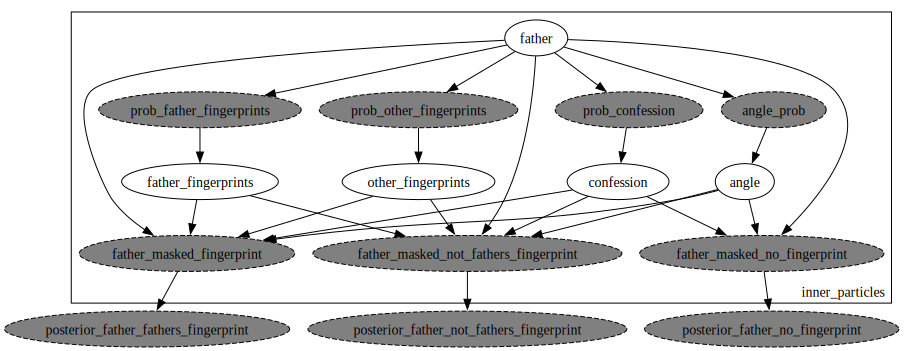

In [12]:
pyro.render_model(tinbox_core_no_son, render_deterministic = True)


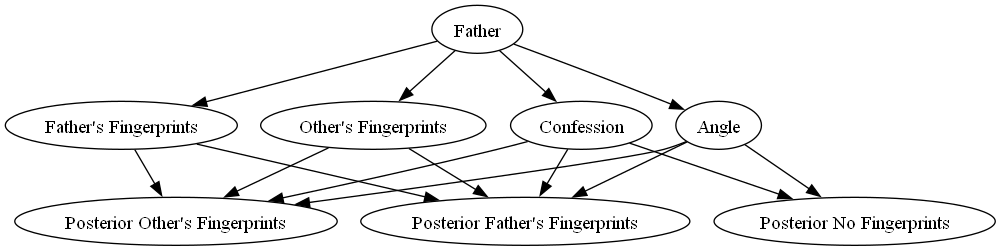

In [41]:
# simplistic DAG

from graphviz import Digraph
from IPython.display import Image, display

dot = Digraph(comment="Modified Murder Case DAG with Other's Fingerprints")

dot.node('father', 'Father')
dot.node('confession', 'Confession')
dot.node('angle', 'Angle')
dot.node('father_fingerprints', 'Father\'s Fingerprints')
dot.node('others_fingerprints', 'Other\'s Fingerprints')
dot.node('posterior_father_fathers_fingerprint', 'Posterior Father\'s Fingerprints')
dot.node('posterior_father_not_fathers_fingerprint', 'Posterior Other\'s Fingerprints')
dot.node('posterior_father_no_fingerprint', 'Posterior No Fingerprints')


dot.edge('father', 'father_fingerprints')
dot.edge('father', 'others_fingerprints')
dot.edge('father', 'confession')
dot.edge('father', 'angle')

dot.edge('father_fingerprints', 'posterior_father_fathers_fingerprint')
dot.edge('father_fingerprints', 'posterior_father_not_fathers_fingerprint')
dot.edge('others_fingerprints', 'posterior_father_not_fathers_fingerprint')
dot.edge('others_fingerprints', 'posterior_father_fathers_fingerprint')

dot.edge('confession', 'posterior_father_fathers_fingerprint')
dot.edge('confession', 'posterior_father_not_fathers_fingerprint')
dot.edge('confession', 'posterior_father_no_fingerprint')

dot.edge('angle', 'posterior_father_fathers_fingerprint')
dot.edge('angle', 'posterior_father_not_fathers_fingerprint')
dot.edge('angle', 'posterior_father_no_fingerprint')

png_path = dot.render('figures/dag_tinbox_father', format='png')  

display(Image(png_path))



Within this chunk we are running the model for `num_particles` times and printing the results of the posterior probabilities.

In [8]:
# extracting the posterior probabilities

with pyro.poutine.trace() as tr:
   pyro.set_rng_seed(42)
   tinbox_core_no_son(num_particles=1e6)

for key in tr.trace.nodes.keys():
        if key.startswith("posterior"):
                print(key, tr.trace.nodes[key]['value'])
                


posterior_father_fathers_fingerprint tensor(0.9985)
posterior_father_no_fingerprint tensor(0.9964)
posterior_father_not_fathers_fingerprint tensor(0.9318)


The following code calculates the expected weight by performing Bayesian inference using posterior probabilities derived from a probabilistic model. It starts by extracting posterior values of the father's guilt given different types of fingerprint evidence (no fingerprints, father's fingerprints, and others' fingerprints). Then, it uses these values to calculate prior probabilities and the likelihood of various pieces of evidence (fingerprints and no fingerprints) given the current belief in the father's guilt.

The posteriors, probs_of_evidence, and prior_now are later used to calculate the expected weight.

In [9]:
# Calculations necessary for the expected weight

#  Posterior of father's guilt given no fingerprints
father_posterior_no_fingerprint = torch.tensor([
    1 - tr.trace.nodes['posterior_father_no_fingerprint']['value'],  # Probability father is innocent
    tr.trace.nodes['posterior_father_no_fingerprint']['value'],      # Probability father is guilty
])

#  Posterior of father's guilt given his fingerprints are found
father_posterior_fathers_fingerprint = torch.tensor([
    1 - tr.trace.nodes['posterior_father_fathers_fingerprint']['value'],  
    tr.trace.nodes['posterior_father_fathers_fingerprint']['value'],     
])

#  Posterior of father's guilt given other (non-father) fingerprints are found
father_posterior_others_fingerprint = torch.tensor([
    1 - tr.trace.nodes['posterior_father_not_fathers_fingerprint']['value'],  
    tr.trace.nodes['posterior_father_not_fathers_fingerprint']['value'],      
])

print('posterior_father_no_fingerprint', father_posterior_no_fingerprint)
print('posterior_father_fathers_fingerprint', father_posterior_fathers_fingerprint)
print('posterior_father_not_fathers_fingerprint', father_posterior_others_fingerprint)

# the core that was used in the model before
pr_father: float = 0.8 
pr_confession_if_father = 0.9
pr_confession_if_not_father = .01
father_fingerprints_if_father = .2
father_fingerprints_if_not_father = .1
other_fingerprints_if_father = .01
other_fingerprints_if_not_father = .2

# Current posterior probability of father's guilt given no fingerprint evidence
pr_father_now = tr.trace.nodes['posterior_father_no_fingerprint']['value']  # father's guilt with no fingerprints evidence

father_prior_now = torch.tensor([1-pr_father_now, pr_father_now]) # Updated prior
print("prior now", father_prior_now)

# Calculating the probability of finding the father's fingerprints, given the current belief in his guilt
pr_fathers_fingerprint_now = pr_father_now * father_fingerprints_if_father + (
    1 - pr_father_now) * father_fingerprints_if_not_father
print("fathers", pr_fathers_fingerprint_now)

# Calculating the probability of finding other fingerprints given the current belief in father's guilt
pr_other_fingerprints_now = pr_father_now * other_fingerprints_if_father + (
    1 - pr_father_now) * other_fingerprints_if_not_father
print("others", pr_other_fingerprints_now)

# Calculating the probability of finding no fingerprints at all
pr_no_fingerprints_now = 1 - pr_fathers_fingerprint_now - pr_other_fingerprints_now
print("none", pr_no_fingerprints_now)


# Creating a tensor containing the probabilities of different types of evidence (fingerprints or no fingerprints)
probs_of_evidence_no_son = torch.tensor([pr_fathers_fingerprint_now, 
                                         pr_other_fingerprints_now, 
                                         pr_no_fingerprints_now])
print('probs_of_evidence_no_son', probs_of_evidence_no_son)

posterior_father_no_fingerprint tensor([0.0036, 0.9964])
posterior_father_fathers_fingerprint tensor([0.0015, 0.9985])
posterior_father_not_fathers_fingerprint tensor([0.0682, 0.9318])
prior now tensor([0.0036, 0.9964])
fathers tensor(0.1996)
others tensor(0.0107)
none tensor(0.7897)
probs_of_evidence_no_son tensor([0.1996, 0.0107, 0.7897])


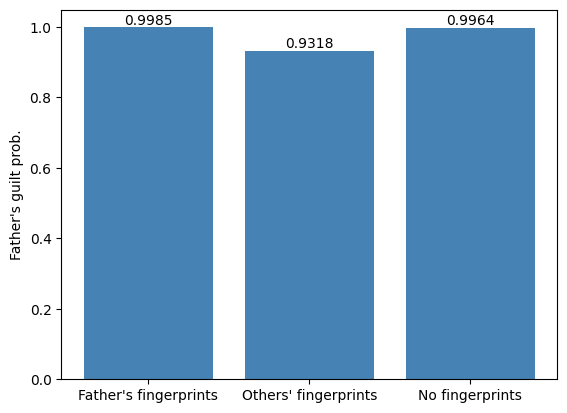

In [31]:
# Visualization that represents posterior probabilities

labels = ['Father\'s fingerprints', 'Others\' fingerprints', 'No fingerprints']

values = [father_posterior_fathers_fingerprint[1],  father_posterior_others_fingerprint[1], father_posterior_no_fingerprint[1]]

fig, ax = plt.subplots()
bars = ax.bar(labels, values, color= 'steelblue')

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

ax.set_ylabel("Father's guilt prob.")
#ax.set_title('Posterior Probs. (no son scenario)')

plt.savefig('figures/tinbox_posterior_probs_no_son.pdf') 
plt.show()

In [12]:
expected_weights_no_son = expected_weight(
    probs_of_evidence_no_son, father_prior_now, 
    [father_posterior_fathers_fingerprint, father_posterior_others_fingerprint, 
     father_posterior_no_fingerprint]
     )


# posterior weights: A tensor of weights calculated for each of the posterior distributions. Each posterior represents a belief after observing some evidence
# weight changes: The difference between the weights of the posteriors and the prior
# weighted weight changes: The weight_changes values multiplied by the probabilities of the corresponding pieces of evidence


print(expected_weights_no_son)

tensor([0.9841, 0.6408, 0.9659])
{'expected_weight': tensor(0.0001), 'weight_prior': 0.965921726077795, 'posterior_weights': tensor([0.9841, 0.6408, 0.9659]), 'weight_changes': tensor([ 0.0181, -0.3252,  0.0000]), 'weighted_weight_changes': tensor([ 0.0036, -0.0035,  0.0000])}


add to the vis. below: probs_of_evidence_no_son tensor([0.1996, 0.0107, 0.7897])

Add a description and explanation of the calculations below:


Expected weight (no son): tensor(0.0001)


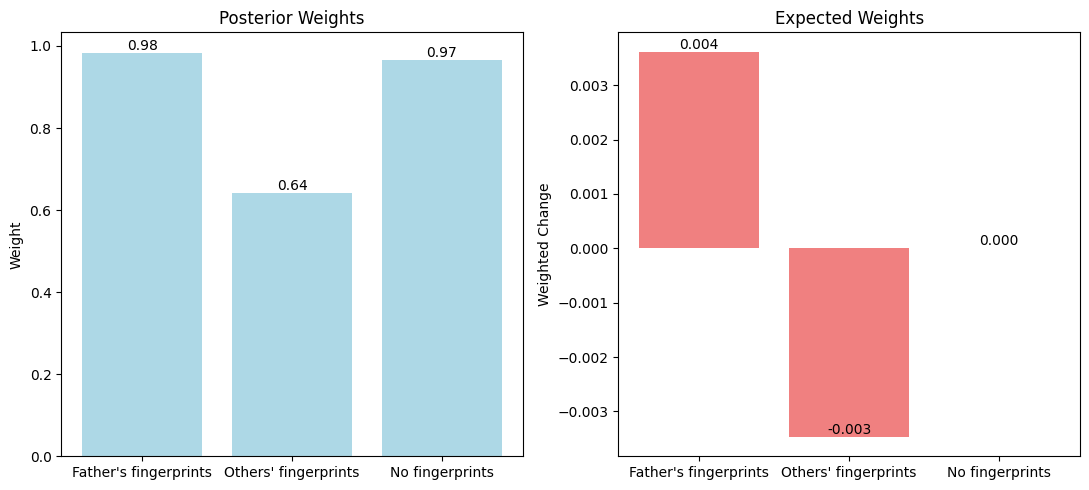

In [30]:
# Visualization of the expected weight calculation

posterior_weights = expected_weights_no_son["posterior_weights"]
weight_changes = expected_weights_no_son["weight_changes"]
weighted_weight_changes = expected_weights_no_son["weighted_weight_changes"]

print('Expected weight (no son):', expected_weights_no_son["expected_weight"])

labels = ['Father\'s fingerprints', 'Others\' fingerprints', 'No fingerprints']

fig, axs = plt.subplots(1, 2, figsize=(11, 5))

axs[0].bar(labels, posterior_weights, color= 'lightblue')
axs[0].set_title('Posterior Weights')
axs[0].set_ylabel('Weight')
for i, v in enumerate(posterior_weights):
    axs[0].text(i, v, f"{v:.2f}", ha='center', va='bottom')

axs[1].bar(labels, weighted_weight_changes, color='lightcoral')
axs[1].set_title('Expected Weights') # Weighted Weight Changes
axs[1].set_ylabel('Weighted Change')
for i, v in enumerate(weighted_weight_changes):
    axs[1].text(i, v, f"{v:.3f}", ha='center', va='bottom')
    
# axs[1].bar(labels, weight_changes, color='lightgreen')
# axs[1].set_title('Weight Changes (Posteriors - Prior)')
# axs[1].set_ylabel('Weight Change')
# for i, v in enumerate(weight_changes):
#     axs[1].text(i, v, f"{v:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.savefig('figures/tinbox_posterior_weights_no_son.pdf') 
plt.show()

## Simple tinbox case with the son in consideration

We will follow here the same workflow as in the previous case, but now we will consider the son. So building the model, calculating the posterior and expected weight.

In [42]:
#set pyro seed
pyro.set_rng_seed(42)
def tinbox_core_son(
        pr_father: float = 0.8, 
        pr_confession_if_father = 0.9,
        pr_confession_if_not_father = .8, # Probability of confession if father is NOT guilty is 0.8 (higher), whereas in the previous model it was 0.01.
        father_fingerprints_if_father = .2,
        father_fingerprints_if_not_father = .1,
        son_fingerprints_if_father = .1, # This model introduces son’s fingerprints
        son_fingerprints_if_not_father = .2,
        angle_if_father = .4,
        angle_if_not_father = .8, 
        num_particles = 3e4#should be wide uniform really
        ):
        with pyro.plate("inner_particles", size=num_particles):
                father = pyro.sample("father", dist.Bernoulli(pr_father))

                prob_confession = pyro.deterministic("prob_confession",
                        father * pr_confession_if_father + (1-father) * pr_confession_if_not_father)
                
                confession = pyro.sample("confession", dist.Bernoulli(prob_confession))

                prob_father_fingerprints = pyro.deterministic("prob_father_fingerprints",
                        father * father_fingerprints_if_father + (1-father) * 
                        father_fingerprints_if_not_father)
                
                father_fingerprints = pyro.sample("father_fingerprints",
                                                   dist.Bernoulli(prob_father_fingerprints))
                
                #  In this model, "other_fingerprints" refers to the son's fingerprints, not unrelated fingerprints like in the first model.
                prob_other_fingerprints = pyro.deterministic("prob_other_fingerprints",
                        father * son_fingerprints_if_father + (1-father) * 
                        son_fingerprints_if_not_father) # The son's fingerprints are now incorporated.
                
                other_fingerprints = pyro.sample("other_fingerprints",
                                                        dist.Bernoulli(prob_other_fingerprints))
                
                angle_prob = pyro.deterministic("angle_prob",
                        father * angle_if_father + (1-father) * angle_if_not_father)
                
                angle = pyro.sample("angle", dist.Bernoulli(angle_prob))

        # a bit hacky, but we want to run it inside other models, so we 
        # avoid running real inference here, using this poor man's 
        # rejection sampling
       
       
        # Evidence masks remain similar to the first model:
        
                evidence_mask_father_fingerprint = (confession  *  angle *
                                        father_fingerprints * (1-other_fingerprints)).bool()

                evidence_mask_no_fingerprint = (confession * angle).bool()

                evidence_mask_not_fathers_fingerprint = (confession  * (
                1-father_fingerprints) * other_fingerprints * angle).bool()

        
                father_masked_fathers_fingerprint = pyro.deterministic("father_masked_fingerprint",
                torch.where(evidence_mask_father_fingerprint, father, torch.tensor(float("nan"))))

                father_masked_no_fingerpint = pyro.deterministic("father_masked_no_fingerprint",
                        torch.where(evidence_mask_no_fingerprint, father, torch.tensor(float("nan"))))
                
                father_masked_not_fathers_fingerprint = pyro.deterministic("father_masked_not_fathers_fingerprint",
                torch.where(evidence_mask_not_fathers_fingerprint, father, torch.tensor(float("nan"))))
        
        
        
        posterior_father_fathers_fingerprint = pyro.deterministic(
                "posterior_father_fathers_fingerprint", torch.nanmean(father_masked_fathers_fingerprint,
                                                                      axis=0))
        
        posterior_father_no_fingerprint = pyro.deterministic(
                "posterior_father_no_fingerprint", torch.nanmean(father_masked_no_fingerpint, axis=0))
        
        
        posterior_father_not_fathers_fingerprint = pyro.deterministic(
                "posterior_father_not_fathers_fingerprint",
                        torch.nanmean(father_masked_not_fathers_fingerprint, axis=0))
        



In [43]:
with pyro.poutine.trace() as tr_son:
   pyro.set_rng_seed(42)
   tinbox_core_son(num_particles=1e6)

for key in tr_son.trace.nodes.keys():
        if key.startswith("posterior"):
                print(key, tr_son.trace.nodes[key]['value'])
                



posterior_father_fathers_fingerprint tensor(0.8337)
posterior_father_no_fingerprint tensor(0.6927)
posterior_father_not_fathers_fingerprint tensor(0.5025)


In [44]:

father_posterior_no_fingerprint = torch.tensor([
    1-tr_son.trace.nodes['posterior_father_no_fingerprint']['value'],
    tr_son.trace.nodes['posterior_father_no_fingerprint']['value'],
                    ])
father_posterior_fathers_fingerprint = torch.tensor([
    1-tr_son.trace.nodes['posterior_father_fathers_fingerprint']['value'],
    tr_son.trace.nodes['posterior_father_fathers_fingerprint']['value'],
                    ])
father_posterior_others_fingerprint = torch.tensor([
    1-tr_son.trace.nodes['posterior_father_not_fathers_fingerprint']['value'],
    tr_son.trace.nodes['posterior_father_not_fathers_fingerprint']['value'],
                    ])

print('Posterior no fingerprints', father_posterior_no_fingerprint)
print("Posterior father's fingerprints", father_posterior_fathers_fingerprint)
print("Posterior other's fingerprints", father_posterior_others_fingerprint)

pr_father: float = 0.8 
pr_confession_if_father = 0.9
pr_confession_if_not_father = .8
father_fingerprints_if_father = .2
father_fingerprints_if_not_father = .1
son_fingerprints_if_father = .1
son_fingerprints_if_not_father = .2
angle_if_father = .4
angle_if_not_father = .8

pr_father_now = tr_son.trace.nodes['posterior_father_no_fingerprint']['value']

father_prior_now = torch.tensor([1-pr_father_now, pr_father_now])

print("prior now", father_prior_now)

pr_fathers_fingerprint_now = pr_father_now * father_fingerprints_if_father + (
    1-pr_father_now) * father_fingerprints_if_not_father

print("fathers", pr_fathers_fingerprint_now)

pr_other_fingerprints_now = pr_father_now * other_fingerprints_if_father + (
    1-pr_father_now) * other_fingerprints_if_not_father

print("others", pr_other_fingerprints_now)

pr_no_fingerprints_now = 1 - pr_fathers_fingerprint_now - pr_other_fingerprints_now

print("none", pr_no_fingerprints_now)

probs_of_evidence_with_son = torch.tensor([pr_fathers_fingerprint_now, 
                                         pr_other_fingerprints_now, pr_no_fingerprints_now,])
print('probs_of_evidence_with_son', probs_of_evidence_with_son)

Posterior no fingerprints tensor([0.3073, 0.6927])
Posterior father's fingerprints tensor([0.1663, 0.8337])
Posterior other's fingerprints tensor([0.4975, 0.5025])
prior now tensor([0.3073, 0.6927])
fathers tensor(0.1693)
others tensor(0.0684)
none tensor(0.7623)
probs_of_evidence_with_son tensor([0.1693, 0.0684, 0.7623])


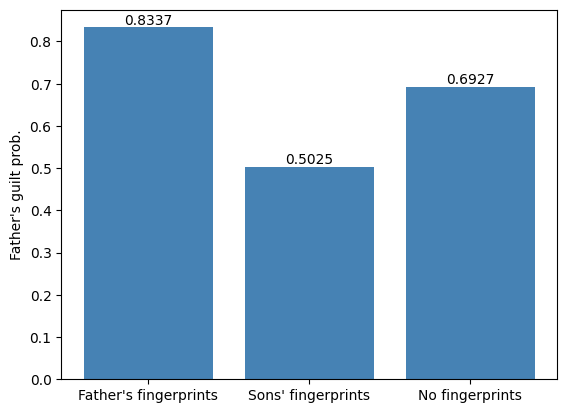

In [54]:
labels = ['Father\'s fingerprints', 'Sons\' fingerprints', 'No fingerprints']
values = [father_posterior_fathers_fingerprint[1],  father_posterior_others_fingerprint[1], father_posterior_no_fingerprint[1]]

fig, ax = plt.subplots()
bars = ax.bar(labels, values, color= 'steelblue')

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

ax.set_ylabel("Father's guilt prob.")
#ax.set_title('Posterior Probs. (son scenario)')
plt.savefig('figures/tinbox_posterior_probs_son.pdf') 

plt.show()

In [50]:
expected_weights_with_son = expected_weight(
    probs_of_evidence_with_son, father_prior_now, 
    [father_posterior_fathers_fingerprint, father_posterior_others_fingerprint, 
     father_posterior_no_fingerprint]
     )

print(expected_weights_with_son)

tensor([3.5076e-01, 1.8597e-05, 1.0992e-01])
{'expected_weight': tensor(0.0332), 'weight_prior': 0.10992085933685303, 'posterior_weights': tensor([3.5076e-01, 1.8597e-05, 1.0992e-01]), 'weight_changes': tensor([ 0.2408, -0.1099,  0.0000]), 'weighted_weight_changes': tensor([ 0.0408, -0.0075,  0.0000])}


Comparison of exp. weights, the scale, is 0.03 a significant difference?

Expected weight (with the son): tensor(0.0332)


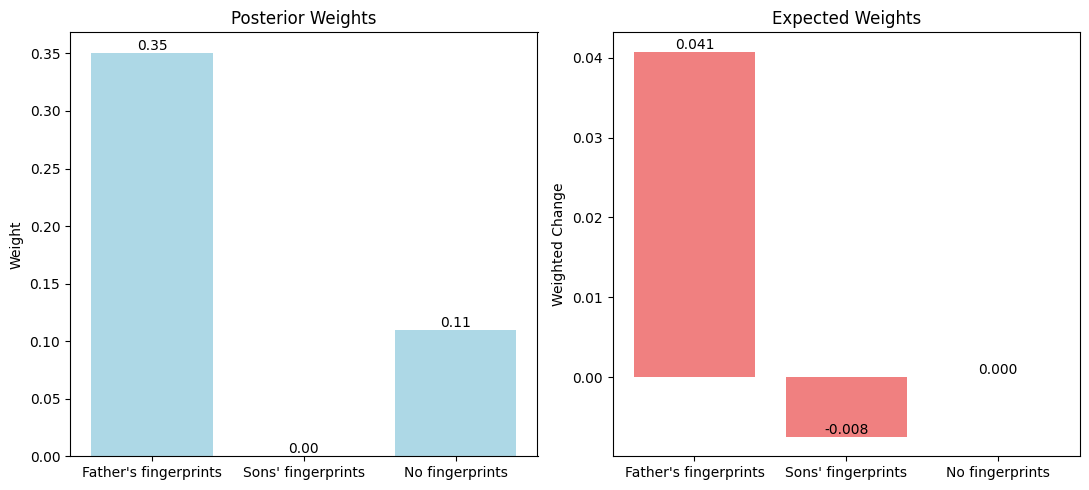

In [56]:

posterior_weights = expected_weights_with_son["posterior_weights"]
weight_changes = expected_weights_with_son["weight_changes"]
weighted_weight_changes = expected_weights_with_son["weighted_weight_changes"]

print('Expected weight (with the son):', expected_weights_with_son["expected_weight"])

labels = ['Father\'s fingerprints', 'Sons\' fingerprints', 'No fingerprints']

fig, axs = plt.subplots(1, 2, figsize=(11, 5))

axs[0].bar(labels, posterior_weights, color= 'lightblue')
axs[0].set_title('Posterior Weights')
axs[0].set_ylabel('Weight')
for i, v in enumerate(posterior_weights):
    axs[0].text(i, v, f"{v:.2f}", ha='center', va='bottom')

# axs[1].bar(labels, weight_changes, color='lightgreen')
# axs[1].set_title('Weight Changes (Posteriors - Prior)')
# axs[1].set_ylabel('Weight Change')
# for i, v in enumerate(weight_changes):
#     axs[1].text(i, v, f"{v:.2f}", ha='center', va='bottom')

axs[1].bar(labels, weighted_weight_changes, color='lightcoral')
axs[1].set_title('Expected Weights')
axs[1].set_ylabel('Weighted Change')
for i, v in enumerate(weighted_weight_changes):
    axs[1].text(i, v, f"{v:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.savefig('figures/tinbox_posterior_weights_son.pdf') 
plt.show()

In [37]:
# bayesian, analyticall approach

P_Father = 0.5
P_Not_Father = 0.5

P_C_given_Father = 0.95  # confession given Father
P_C_given_Not_Father = 0.01  # confession given Not Father

P_A_given_Father = 0.3  # angle given Father
P_A_given_Not_Father = 0.7  # angle given Not Father

P_F_given_Father = 0.9  # dingerprints given Father
P_F_given_Not_Father = 0.1  # fingerprints given Not Father


P_C_A_F_given_Father = P_C_given_Father * P_A_given_Father * P_F_given_Father
P_C_A_F_given_Not_Father = P_C_given_Not_Father * P_A_given_Not_Father * P_F_given_Not_Father


P_C_A_F = (P_C_A_F_given_Father * P_Father) + (P_C_A_F_given_Not_Father * P_Not_Father)


P_Father_given_C_A_F = (P_C_A_F_given_Father * P_Father) / P_C_A_F


P_C_A_given_Father = P_C_given_Father * P_A_given_Father
P_C_A_given_Not_Father = P_C_given_Not_Father * P_A_given_Not_Father


P_C_A = (P_C_A_given_Father * P_Father) + (P_C_A_given_Not_Father * P_Not_Father)


P_Father_given_C_A = (P_C_A_given_Father * P_Father) / P_C_A

print(f" P(Father|C,A,F) = {P_Father_given_C_A_F};   P(Father|C,A) = {P_Father_given_C_A}")

 P(Father|C,A,F) = 0.9972783825816486;   P(Father|C,A) = 0.976027397260274


### Previous approach

In [5]:

def tinbox_core(
    pr_father,
    pr_confession_if_father,
    pr_confession_if_son,
    pr_angle_if_son,
    pr_angle_if_father,
    pr_father_fingerprints_if_father,
    pr_father_fingerprints_if_son,
    pr_son_fingerprints_if_father,
    pr_son_fingerprints_if_son,
    scenario="no_fingerprints",
    angle_value=1  
):
    with pyro.plate("tinbox_core_estimation", size=1e4):
        father = pyro.sample("father", dist.Bernoulli(pr_father))
        son = pyro.deterministic("son", 1 - father, event_dim=0) 

        prob_confession = torch.where(father == 1, pr_confession_if_father, pr_confession_if_son)
        confession = pyro.sample("confession", dist.Bernoulli(prob_confession))

        prob_angle = torch.where(father == 1, pr_angle_if_father, pr_angle_if_son)
        angle = pyro.sample("angle", dist.Bernoulli(prob_angle))

        prob_father_fingerprints = torch.where(father == 1, pr_father_fingerprints_if_father, pr_father_fingerprints_if_son)
        father_fingerprints = pyro.sample("father_fingerprints", dist.Bernoulli(prob_father_fingerprints))

        prob_son_fingerprints = torch.where(father == 1, pr_son_fingerprints_if_father, pr_son_fingerprints_if_son)
        son_fingerprints = pyro.sample("son_fingerprints", dist.Bernoulli(prob_son_fingerprints))


# the possible scenarios
    if scenario == "no_fingerprints":

        evidence_mask = (confession == 1) & (angle == 1)
    elif scenario == "son_fingerprints":

        evidence_mask = (confession == 1) & (angle == 1) & (son_fingerprints == 1) & (father_fingerprints == 0)
    elif scenario == "father_fingerprints":

        evidence_mask = (confession == 1) & (angle == 1) & (son_fingerprints == 0) & (father_fingerprints == 1)
    elif scenario == "no_fingerprints_no_angle":
  
        evidence_mask = (confession == 1) & (angle == 0)
    elif scenario == "son_fingerprints_no_angle":

        evidence_mask = (confession == 1) & (angle == 0) & (son_fingerprints == 1) & (father_fingerprints == 0)
    elif scenario == "father_fingerprints_no_angle":

        evidence_mask = (confession == 1) & (angle == 0) & (son_fingerprints == 0) & (father_fingerprints == 1)
        


    # filtered_son = torch.where(evidence_mask, son, torch.tensor(float("nan")))
    # posterior_son = torch.nanmean(filtered_son, axis=0)
    
    filtered_father = torch.where(evidence_mask, father, torch.tensor(float("nan")))
    posterior_father = torch.nanmean(filtered_father, axis=0)

    return posterior_father


def tinbox_model(scenario):

    pr_father = pyro.sample("pr_father", dist.Uniform(0, 1))


    pr_confession_if_father = pyro.sample("pr_confession_if_father", dist.Beta(5, 6))
    pr_confession_if_son = pyro.sample("pr_confession_if_son", dist.Beta(6, 5))


    pr_angle_if_son = pyro.sample("pr_angle_if_son", dist.Beta(8, 5))
    pr_angle_if_father = pyro.sample("pr_angle_if_father", dist.Beta(5, 8))

    pr_father_fingerprints_if_father = pyro.sample(
        "pr_father_fingerprints_if_father", dist.Beta(999, 3)
    )
    pr_father_fingerprints_if_son = pyro.sample(
        "pr_father_fingerprints_if_son", dist.Beta(5, 96)
    )
    pr_son_fingerprints_if_father = pyro.sample(
        "pr_son_fingerprints_if_father", dist.Beta(5, 96)
    )
    pr_son_fingerprints_if_son = pyro.sample(
        "pr_son_fingerprints_if_son", dist.Beta(999, 3)
    )

    posterior_father = tinbox_core(
        pr_father,
        pr_confession_if_father,
        pr_confession_if_son,
        pr_angle_if_son,
        pr_angle_if_father,
        pr_father_fingerprints_if_father,
        pr_father_fingerprints_if_son,
        pr_son_fingerprints_if_father,
        pr_son_fingerprints_if_son,
        scenario=scenario
    )


   # pyro.deterministic("posterior_son", posterior_son, event_dim=0)
    pyro.deterministic("posterior_father", posterior_father, event_dim=0)
    


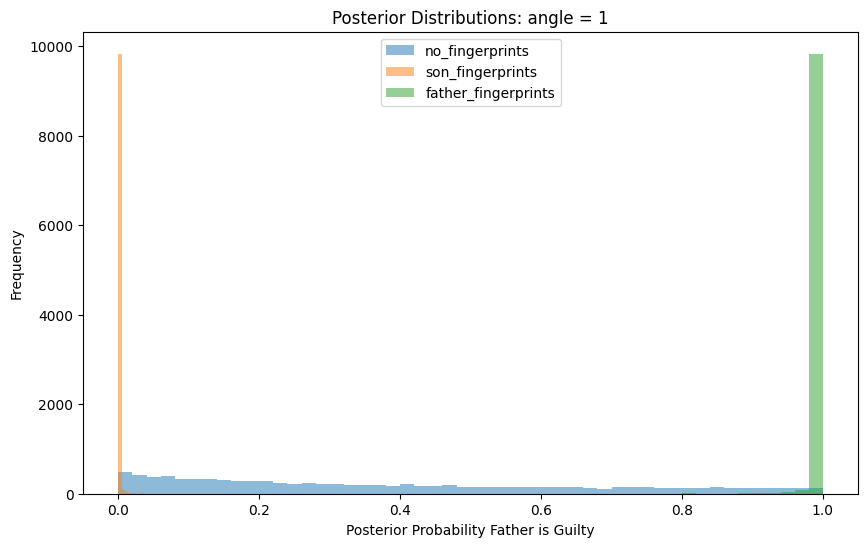

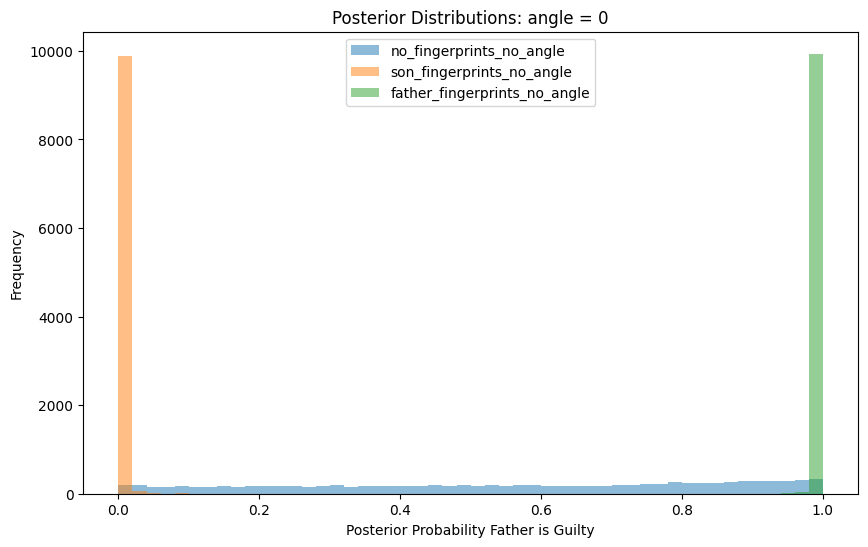

In [6]:

# Running the model for different scenarios    

def run_scenarios(angle):
    
    if angle == 1:
    
        scenarios = ["no_fingerprints", "son_fingerprints", "father_fingerprints"]
        
    elif angle == 0:
        scenarios = ["no_fingerprints_no_angle", "son_fingerprints_no_angle", "father_fingerprints_no_angle"]
        
    results = {}
    
    for scenario in scenarios:
        with pyro.plate("samples", size=10000):
            with pyro.poutine.trace() as tr:
                tinbox_model(scenario)
        results[scenario] = tr.trace.nodes["posterior_father"]["value"].detach().numpy()
    
    return results

scenario_posteriors_angle = run_scenarios(angle=1)
scenario_posteriors_no_angle = run_scenarios(angle=0)


# plot for angle=1

plt.figure(figsize=(10, 6))

for scenario, posterior in scenario_posteriors_angle.items():
    plt.hist(posterior, bins=50, alpha=0.5, label=scenario)

plt.title("Posterior Distributions: angle = 1")
plt.xlabel("Posterior Probability Father is Guilty")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# no angle plot


plt.figure(figsize=(10, 6))

for scenario, posterior in scenario_posteriors_no_angle.items():
    plt.hist(posterior, bins=50, alpha=0.5, label=scenario)

plt.title("Posterior Distributions: angle = 0")
plt.xlabel("Posterior Probability Father is Guilty")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Weights

In [7]:
# function for calculating weights of all the scenarios
def calculate_weights(scenario: Dict[str, List[float]]) -> Dict[str, float]:
    weights = {}
    for key, posterior in scenario.items():
        weight_value = weight(posterior) 
        weights[key] = weight_value
    return weights

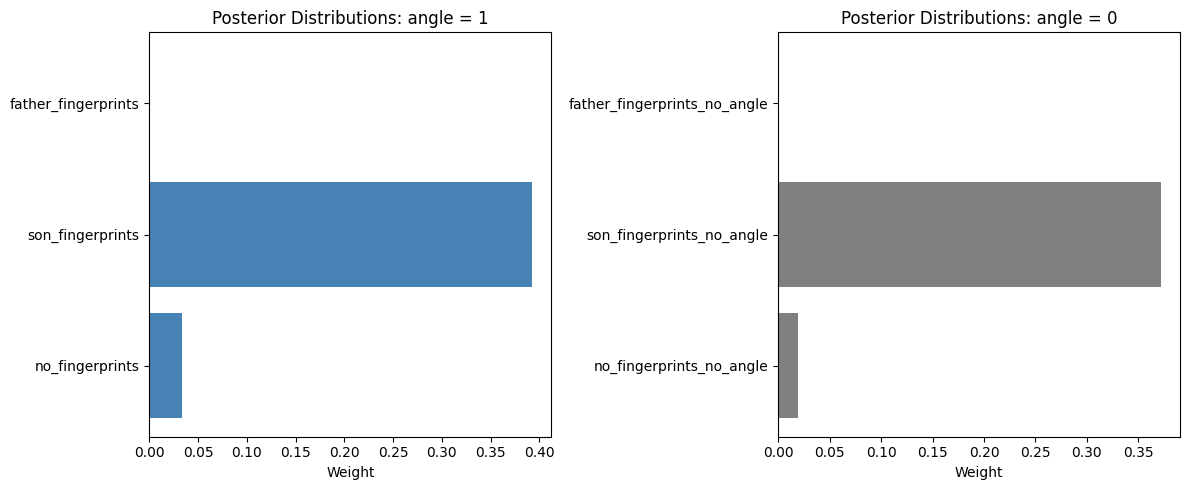

In [8]:
weights_angle = calculate_weights(scenario_posteriors_angle)
weights_no_angle = calculate_weights(scenario_posteriors_no_angle)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].barh(list(weights_angle.keys()), list(weights_angle.values()), color='steelblue')
axs[0].set_title('Posterior Distributions: angle = 1')
axs[0].set_xlabel('Weight')


axs[1].barh(list(weights_no_angle.keys()), list(weights_no_angle.values()), color='gray')
axs[1].set_title('Posterior Distributions: angle = 0')
axs[1].set_xlabel('Weight')

plt.tight_layout()
plt.show()

Condition and intervention approach graveyard

In [9]:
# conditioned_model = pyro.condition(
#     tinbox_model, 
#     data={
#         "father": torch.tensor(0.0),  # Son did it
#         "father_fingerprints": torch.tensor(0.0),  # Son's fingerprints
#         "angle": torch.tensor(0.9)  
#     }
# )


# with pyro.plate("samples", 10000):
#     with pyro.poutine.trace() as tr_uncond:
#         posterior_uncond = tinbox_model()

# nodes_uncond = tr_uncond.trace.nodes


# for key in nodes_uncond.keys():
#     if key.startswith("posterior"):
#         plot_site(nodes_uncond, key)
        

# for key in nodes_cond.keys():
#     if key.startswith("posterior"):
#         plt.figure()
#         plt.hist(nodes_uncond[key]["value"].detach().numpy(), bins=50, alpha=0.5, label="Unconditioned")
#         # plt.hist(nodes_cond[key]["value"].detach().numpy(), bins=50, alpha=0.5, label="Conditioned")
#         plt.title(f"Comparison for {key}")
#         plt.legend()
#         plt.show()




# intervention_model = pyro.do(
#     tinbox_model, 
#     data={
#         "father_fingerprints": torch.tensor(1.0), 
#     }
# )


# posterior = intervention_model()
# weight_value = weight(posterior)
# weight_value

## Ways to visualize DAGs

Graphviz


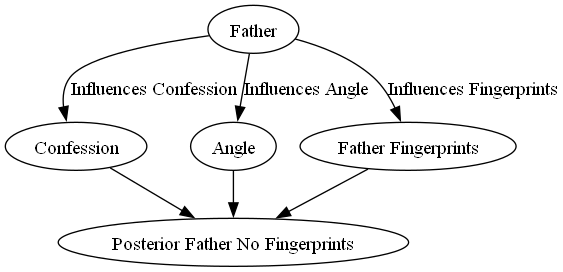

In [12]:
from graphviz import Digraph
from IPython.display import Image, display

dot = Digraph(comment="Murder Case DAG")

dot.node('F', 'Father')
dot.node('C', 'Confession')
dot.node('A', 'Angle')
dot.node('FF', 'Father Fingerprints')
dot.node('P', 'Posterior Father No Fingerprints')

dot.edge('F', 'C', label="Influences Confession")
dot.edge('F', 'A', label="Influences Angle")
dot.edge('F', 'FF', label="Influences Fingerprints")
dot.edge('C', 'P')
dot.edge('A', 'P')
dot.edge('FF', 'P')


png_path = dot.render('murder_case_dag', format='png') # saving the PNG

display(Image(png_path))


Dagitty


In [ ]:
# library(dagitty)
# library(ggplot2)

# dag <- dagitty('
#     dag {
#         Father [label="Father"]
#         Confession [label="Confession"]
#         Angle [label="Angle"]
#         FatherFingerprints [label="Father Fingerprints"]
#         PosteriorFatherNoFingerprints [label="Posterior Father No Fingerprints"]
#         Father -> Confession
#         Father -> Angle
#         Father -> FatherFingerprints
#         Confession -> PosteriorFatherNoFingerprints
#         Angle -> PosteriorFatherNoFingerprints
#         FatherFingerprints -> PosteriorFatherNoFingerprints
#     }
# ')

# plot(dag)

# p <- plot(dag)
# ggsave("dag_plot_no_abbreviations.png", plot = p)


![](tinbox_dagitty_plot.png){ fig-align="center" width="60%"}